In [3]:
from IPython.display import Image

from matplotlib import pyplot as plt
import numpy as np
from numpy.random import normal, binomial, choice
import pandas as pd
from scipy import stats
import seaborn as sns


px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
plt.rcParams["figure.figsize"] = (600 * px, 400 * px)
%matplotlib widget

## Chapter 3: Finite Markov Decision Problems

- This chapter introduces finite Markov Decision Processes (MDPs) as a general framing of the RL problem: learning from interaction to achieve a goal.
- MDP problems involve **evaluative feedback** (as in bandit problems), but also **association** - learning to associate certain actions with certain situations. 
- In MDP problems actions influence not just immediate rewards (as in bandit problems), but also subsequent states, actions, and rewards.
- In bandit problems we estimated action-values, $q_*(a)$; in MDPs we estimate state-action-values, $q_*(s, a)$ and state-values, $v_*(s)$.

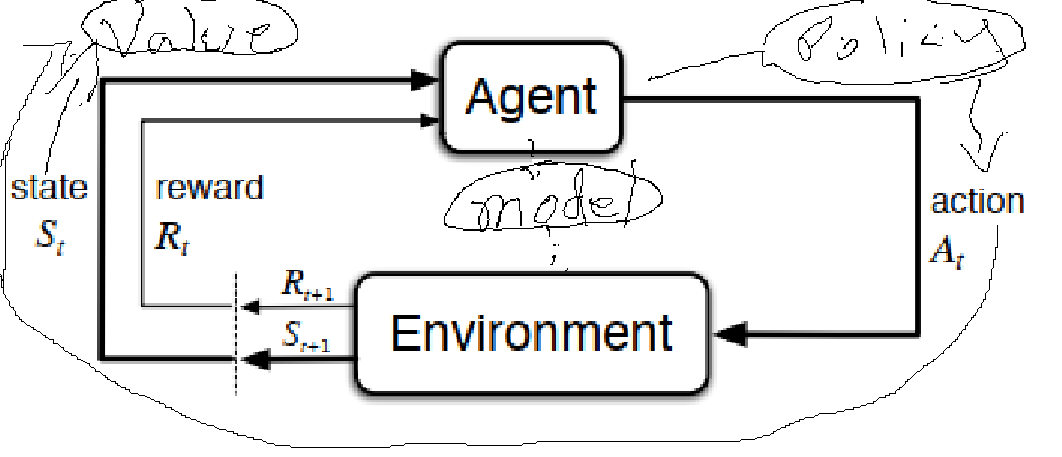

In [11]:
Image(r"images/RL_MDP_diagram.png", width=600)

## 3.1: The Agent-Environment Interface

- In framing an RL problem using an MDP, at each of a sequence of discrete time steps $t= 0, 1, 2, ...$, an agent interacts with an environment and receives some representation of the environment's state, $s_t \in S$, on which basis the agent selects an action, $a_t \in A(s_t)$, on which basis, at the next time step, it receives a numerical reward, $r_{t+1} \in R \subset \mathbb{R}$. 
- In a _finite_ MDP, the sets of states, actions, and rewards ($S, A, R$) all have a finite number of elements.
- The state, action, reward sequence (aka "trajectory") looks like this: $S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, ...$
- Performing a particular action $a$ in a particular state $s$, the probability of entering all possible successor states ($s' \in S(a)$) with particular rewards ($r \in R(a)$) sums to 1, and can be represented by:
$$\begin{equation}\begin{aligned}
\sum_{s' \in S(a)} \sum_{r \in R(a)} p(s', r \mid s, a) = 1 && \text{for each } s \in S, a \in A(s)
\end{aligned}\end{equation}\tag{3.3}$$
- The probabilities given by $p$ completely characterize the environment's dynamics: the probability of each possible value for $S_{t}$ and $R_{t}$ depends only on the immediately preceding state and action, $S_{t-1}$ and $A_{t-1}$.
  - This is best viewed not as a restriction on the decision process, but just on the state: the state must include information about all aspects of the past agent-environment interactions that are relevant for the future. 
    - If this is the case, the state (and if true for all states, then by extension the decision process) is said to have the **Markov property**.
      - Unless stated otherwise, this textbook assumes by default that decision processes have the Markov property.
- Given an MDP which has the Markov property and the four-argument dynamics function $p$ (3.3), we can compute anything else we might want to know about the environment, such as the state-transition probabilities:
$$\begin{equation}\begin{aligned}
p(s' \mid s, a) = \sum_{r \in R} p(s', r \mid s, a) 
\end{aligned}\end{equation}\tag{3.4}$$
the expected rewards for state-action pairs:
$$\begin{equation}\begin{aligned}
r(s, a) = \sum_{r \in R}r \sum_{s' \in S} p(s', r \mid s, a) 
\end{aligned}\end{equation}\tag{3.5}$$
and the expected rewards for state-action-successor_state triples:
$$\begin{equation}\begin{aligned}
r(s, a, s') = \sum_{r \in R}r \frac{p(s', r \mid s, a)}{p(s' \mid s, a)} 
\end{aligned}\end{equation}\tag{3.6}$$
- The MDP framework can be abstract and flexible and applied to many different problems in many different ways:
  - Time-steps need not refer to fixed intervals of real time; they can refer to any arbitrary successive stages of decision-making and acting
  - Actions can be low-level controls, such as voltages applied to motors, or high-level decisions, such as where to have lunch.
  - States can be completely determined by low-level sensations, such as direct sensor readings, or can be abstract and high-level, such as an agent's level of surprise.
  - The boundary between agent and environment can be broad or narrow: typically the more detail, the more narrow (e.g. if we consider the mechanical linkages of a robot in an MDP, these would belong to the environment rather than the agent).
    - The general rule followed is that anything that canot be changed arbitrarily by the agent is considered to belong to its environment.
    - The agent-environment boundary represents the limit of the agent's _control_, not of its knowledge: in some cases the agent may know a lot about the environment and still face a difficult RL task in optimizing reward (e.g. solving a maze).
- Overall, the MDP framework is a considerable abstraction of the problem of goal-directed learning from interaction: it proposes that learning goal-directed behavior can be reduced to three signals which pass back and forth between an agent and its environment: 1) states, 2) actions, 3) rewards.

### Example 3.3: Recycling Robot

A mobile robot has the job of collecting empty soda cans in an office environment. It has two states: `high`-battery, and `low`-battery. In a `high` state it can choose two actions: either `search` or `wait`, and in a low state it can additionally choose a third action: `recharge`. Each step on which it collects a can results in a reward of 1, and a step in which it runs out of battery results in a reward of -3 and a recharge (by a nice human) back to the high state. The E.V. reward for `search`ing, $r_{search}$ is higher than the E.V. reward for `wait`ing, $r_{wait}$.

The figure below shows:
  - On the left: the complete table for all possible state-action-successor_state triples, along with the probability of entering each successor state given a particular state-action pair, and the reward for entering that successor state. 
  - On the right: the MDP transition graph: the large circles represent the two states - high (left) and low (right) - and the small circles represent the possible actions from each state.

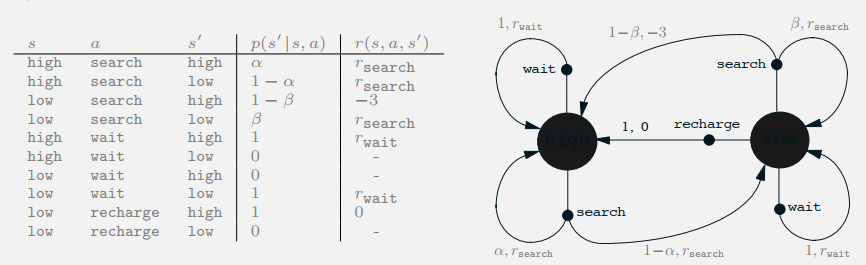

In [12]:
Image(r"images/recycling_robot.png", width=1000)

### 3.1 Exercises:

*Exercise 3.2: Is the MDP framework adequate to usefully represent all goal-directed learning tasks? Can you think of any clear exceptions?*

The MDP framework **cannot** adequately represent **all** goal-directed learning tasks: one key assumption in MDPs is the Markov property - if this is broken (e.g. if the probability of taking some action $a_{t}$ and receiving some reward $r_{t+1}$ and entering some state $s_{t+1}$ depends not only on $a_{t-1}$ and $s_{t-1}$ but also on $a_{t-2}$ and $s_{t-2}$) then the MDP framework will fail to accurately predict $a_{t}$  $r_{t+1}$ and $s_{t+1}$.

*Exercise 3.3: Consider the problem of driving. You could define the actions in terms of the accelerator, steering wheel, and brake, that is, where your body meets the machine. Or you could define them farther out — say, where the rubber meets the road, considering your actions to be tire torques. Or you could define them farther in — say, where your brain meets your body, the actions being muscle twitches to control your limbs. Or you could go to a really high level and say that your actions are your choices of where to drive. What is the right level, the right place to draw the line between agent and environment? On what basis is one location of the line to be preferred over another? Is there any fundamental reason for preferring one location over another, or is it a free choice?*

When designing an agent to solve an MDP, the right choice on where to draw the boundary between agent and environment depends on the level of detail known / wished to be known about the entire MDP and the specifics of the goal(s) of the agent. For example, in the above mentioned problem of driving, we may prefer to define the actions in terms of the accelerator, steering wheel, and brake if we care to learn the responsiveness (e.g. sensitivity) of each of these components, or we may prefer to define actions in terms of choices of where to drive if we care to learn that in certain timesteps/situations we should drive to one particular place (e.g. when we are low on gas, to the gas station, or when we are hungry, to a grocery store).

*Exercise 3.4: Give a table analogous to that in Example 3.3, but for $p(s', r \mid s, a)$. It should have columns for $s$, $a$, $s'$, $r$, and $p(s', r \mid s, a)$, and a row for every 4-tuple for which  $p(s', r \mid s, a)$.*


|s    | a          |s'   |r            |$p$                  |
|---  |---         |---  |---          |---                  |                                  
|high |search      |high |search       | $\alpha$            |
|high |search      |low  |search       | 1 - $\alpha$        |
|high |wait        |high |wait         | 1                   |
|low  |search      |low  |search       | $\beta$             |
|low  |search      |high |-3           | 1 - $\beta$         |
|low  |wait        |low  |wait         | 1                   |
|low  |recharge    |high |0            | 1                   |






## 3.2 Goals and Rewards

- In RL, the agent's goal is to maximize cumulative reward in the long run. This is known as the **reward hypoythesis**.
    - Typically, reward is a scalar signal. We can also have distributional rewards (e.g. in distributional RL), but that is outside the scope of this textbook.
- The reward signal is typically only a way to communicate to the agent _what_ we want it to achieve, _not_ _how_.

## 3.3 Returns and Episodes

- **Episodic tasks**
  - "Maximizing cumulative reward in the long run" can be defined more formally as maximizing the **expected return**, which we can define as:
  $$\begin{equation}
  G_t = R_{t+1} + R_{t+2} + ... R_T
  \end{equation}\tag{3.7}$$
  - This approach makes sense in applications in which there is a clear notion of a final time step: when agent-environment interactions break naturally into sequences, also called episodes.
- **Continuing tasks**
  - In contrast, some MDP problems do not break clearly into episodes, but go on continually. In this case, to maximize cumulative reward in the long run and avoid the problem of infinities, we add the notion of **discounted reward**, where the "discount" the value of subsequent rewards from a time $t$. We define this as:
  $$\begin{equation}
  G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3}... = \sum_{k=0}^{\infty} \gamma^k R_{t+1+k}
  \end{equation}\tag{3.8}$$
  - The closer $\gamma$ is to $0$ $(1)$ the more "myopic" ("farsighted") the agent is, being concerned with maximizing more immediate (more uniformly, immediate _and_ future) rewards.
  - We can also define the expected return recursively, as:
  $$\begin{equation}
  G_t = R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3}... = R_{t+1} + \gamma G_{t+1}
  \end{equation}\tag{3.9}$$
  and if reward is nonzero and constant and $\gamma < 1$, we can define the expected return as:
  $$\begin{equation}
  G_t = \sum_{k=0}^{\infty} r\gamma^k = \frac{r}{1 - \gamma}
  \end{equation}\tag{3.10}$$

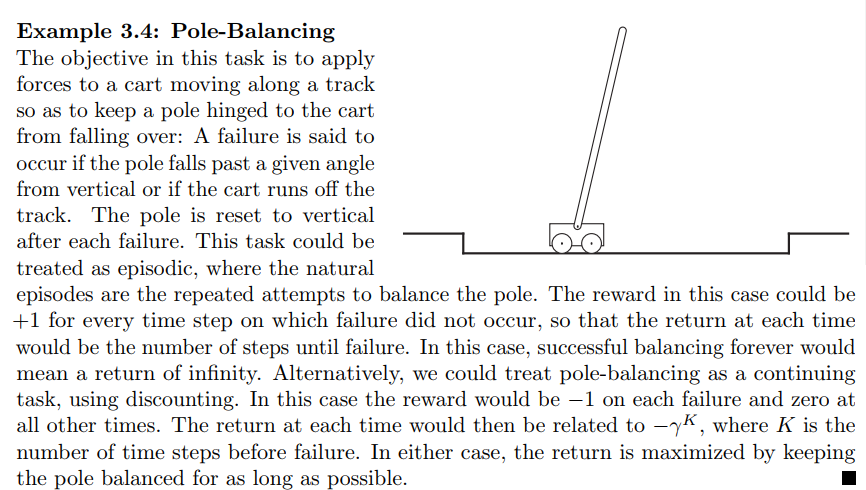

In [13]:
Image(r"images/pole_balancing.png", width=800)

### 3.3 Exercises

*Exercise 3.6: Suppose you treated pole-balancing as an episodic task but also used discounting, with all rewards zero except for -1 upon failure. What then would the return be at each time? How does this return differ from that in the discounted, continuing formulation of this task?*

For an episodic discounted task, we just take the continuing discounted task return function and replace the $\infty$ in the summation upper-bound with $T-t$ (the terminal reward number $T$ minus the current reward number $t$), and we get 
$$
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+1+k}
$$
which for this example equals 
$$
\gamma^{T-t} (-1) = - \gamma^{T-t}
$$
This formulation is equivalent to that of the continuing discounted case.

*Exercise 3.7: Imagine that you are designing a robot to run a maze. You decide to give it a reward of +1 for escaping from the maze and a reward of zero at all other times. The task seems to break down naturally into episodes — the successive runs through the maze — so you decide to treat it as an episodic task, where the goal is to maximize expected total reward (3.7). After running the learning agent for a while, you find that it is showing no improvement in escaping from the maze. What is going wrong? Have you effectively communicated to the agent what you want it to achieve?*

If we take this approach, we are just rewarding the agent from escaping the maze, with no regard to how quickly it escapes the maze. One way to reformulate this would be to receive a reward of -1 on every step it doesn't escape the maze.

*Exercise 3.8: Suppose $\gamma$ = 0.5 and the following sequence of rewards is received $R_1$ = -1, $R_2$ = 2, $R_3$ = 6, $R_4$ = 3, and $R_5$ = 2, with T = 5. What are $G_0, G_1, . . ., G_5$? Hint: Work backwards*

$$\begin{align}
G_5 &= 0 \text{(terminal state)} \\
G_4 &= 2 + 0.5(0) = 2 \\
G_3 &= 3 + 0.5(2) = 4 \\
G_2 &= 6 + 0.5(4) = 8 \\
G_1 &= 2 + 0.5(8) = 6 \\
G_0 &= -1 + 0.5(6) = 2 
\end{align}$$

*Exercise: 3.9 Suppose $\gamma$ = 0.9 and the reward sequence is $R_1 = 2$ followed by an infinite sequence of 7s. What are $G_1$ and $G_0$?*

From 3.10, we can do:
$$\begin{align}
G_1 &= \sum_{k=1}^{\infty} 7(0.9^k) = \frac{7}{1 - 0.9} = 70 \\
G_0 &= 2 + 0.9(70) = 65
\end{align}$$

*Exercise 3.10: Prove the second equality in (3.10)*

For $k \in [0, 1)$, we want to prove that:
$$
\sum_{k=0}^{\infty} \gamma^k = \frac{1}{1 - \gamma}
$$
We'll do this by proving that:
$$
\left(\sum_{k=0}^{\infty} \gamma^k\right) (1 - \gamma) = 1
$$
Proof:
$$\begin{align}
&\left(\sum_{k=0}^{\infty} \gamma^k\right) (1 - \gamma) \\
&=\sum_{k=0}^{\infty} \gamma^k (1 - \gamma) \\
&=\sum_{k=0}^{\infty} \gamma^k - \gamma^{k+1} \\
&=(1 - \gamma) + (\gamma - \gamma^2) + \sum_{k=2}^{\infty} \gamma^k - \gamma^{k+1} \\
&=1 - \underset{k \to \infty}{\operatorname{lim}} \gamma^{k+1} = 1
\end{align}$$

## 3.4 Unified Notation for Episodic and Continuing Tasks

- Technically, to be precise about formulations of episodic tasks when writing $S$, $A$, $R$, etc... we should refer not only to a time-step $t$, but also to the episode number, $i$. However, generally when stating something about episodic tasks it is a statement that is true for all episodes, so we abuse notation and simplify e.g. $S_{t, i}$ to $S_t$.
- It would be nice to have a single notation that covers both episodic and continuing tasks. We can do this by turning the episodic task into a continuing task in which the terminal state is a special "absorbing state" that transitions only to itself with reward 0.
  - Thus we can define the return according to (3.8) including the possibility that $\gamma = 1$ if the sum remains defined (all episodes terminate)
  - Alternatively, including the possibility that $T = \infty \text{ or } \gamma = 1$ (but not both because we'd get an infinite return), we can define the return as:
  $$\begin{equation}
  G_t = \sum_{k = t + 1}^{T} \gamma^{k-t-1} R_k
  \end{equation}\tag{3.11}$$

## 3.5 Policies and Value Functions

- A **policy** defines how an agent should act in certain states. We denote this with $\pi$. $\pi(a \mid s)$ is the probability that $A_t = a$ at $S_t = s$.
- The **value function** of a state $s$ under policy $\pi$ is denoted $v_\pi(s)$ and is the expected return when starting in $s$ and following $\pi$ thereafter. We call $v_\pi$ the **state-value function** and can define it formally as:
$$\begin{equation}
v_\pi(s) = \mathbb{E}_\pi[G_t \mid S_t = s] = \mathbb{E}_\pi \left[\sum_{k=0}^{\infty} \gamma^k R_{t+1+k} \bigg\vert S_t = s \right] 
\end{equation}\tag{3.12}$$
- Similarly, the **value function** of an action $a$ in a state $s$ under policy $\pi$ is denoted $q_\pi(s, a)$ and is the expected return when starting in $s$, taking action $a$, and following $\pi$ thereafter. We call $q_\pi$ the **action-value function** and can define it formally as:
$$\begin{equation}
q_\pi(s, a) = \mathbb{E}_\pi[G_t \mid S_t = s, A_t = a] = \mathbb{E}_\pi \left[\sum_{k=0}^{\infty} \gamma^k R_{t+1+k} \bigg\vert S_t = s, A_t = a \right] 
\end{equation}\tag{3.13}$$
- In practice, $v_\pi$ and $q_\pi$ are estimated from experience.
  - For example, if an agent follows policy $\pi$ and maintains an average of the actual returns for each action taken in each state, these values will converge to the true action-value function $q$.
    - This can be considered a **Monte Carlo** estimation method because it involves averaging over many random samples of returns.
- A fundamental property of value functions used in RL is that they satisfy recursive relationships similar to that we have seen already established for the return (3.9). For $v$ we can see:
$$\begin{equation}\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_t \mid S_t = s] \qquad \text{(from (3.9))} \\
&= \mathbb{E}_\pi[R_{t + 1} + \gamma G_{t+1} \mid S_t = s] \\
&= \sum_{a} \pi(a \mid s) \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma \mathbb{E}_\pi[G_{t+1} \mid S_{t+1} = s'] \right] \\
&= \sum_{a} \pi(a \mid s) \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma v_\pi(s')] \right]
\end{aligned}\end{equation}\tag{3.14}$$
  - The final expression can be read easily as an E.V.: it is a sum over values of $a, s', r$ where for each triple we compute it's probability, $\pi(a \mid s) p(s', r \mid s, a)$, weight the reward + expected future return, $[r + \gamma v_\pi(s')]$, by this probability, and sum over all possibilities to get an E.V.
  - This equation is known as the **Bellman equation** for $v_\pi$. It expresses the relationship between the value of a state and its successor states: the value of a state must equal the current reward + the (discounted) values of the successor states.
    - The value function of a policy is the unique solution to its Bellman equation.
- *Note*: for finite MDPs, if we ignore action policy ($\pi$), we can solve for the Bellman equation for $v$ using linear algebra: the Bellman equation is a system of equations, one for each state, so if there are $n$ states, we have $n$ equations and $n$ unknowns (the value-function of each state) and we can write this in matrix form as:
$$\begin{equation}
\begin{bmatrix}
v_1 \\
v_2 \\
\vdots \\
v_n
\end{bmatrix} 
= \begin{bmatrix}
R_1 \\
R_2 \\
\vdots \\
R_n
\end{bmatrix} 
+ \gamma \begin{bmatrix}
p_{11} & p_{12} & \cdots & p_{1n} \\
p_{21} & p_{22} & \cdots & p_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
p_{n1} & p_{n2} & \cdots & p_{nn}
\end{bmatrix}
\begin{bmatrix}
v_1 \\
v_2 \\
\vdots \\
v_n
\end{bmatrix} 
\end{equation}\tag{a3.14.0}$$
where the $R$ vector represents the rewards, the $p$ matrix represents the probability state-transition matrix, the $v$ vector on the RHS represents the initial value-function values, and on the LHS represents the updated values. 
  - *(n.b. as mentioned above, this does **not** include actions. When we consider taking actions, we get a $p$ matrix for each state-value function (each element in $v$), where the number of rows in this $p$ matrix represent each possible action for the given state)*.
  - We can solve for $v$ algebraically as:
  $$\begin{equation}\begin{aligned}
  v &= R + \gamma P v \\
  v - \gamma P v &= R \\
  (I - \gamma P) v &= R \\
  v &= (I - \gamma P)^{-1} R
  \end{aligned}\end{equation}\tag{a3.14.1}$$
  but in practice this is very expensive (particularly the matrix inversion, and overall $O(n^3)$) for large-state problems and so we typically use iterative methods to (approximately) solve for $v$.
- The backup diagram below illustrates the _backup_ operations that are are at the heart of reinforcement learning methods: these operations transfer value information _back_ to a state (state-action pair) from its successor states (state-action pairs).

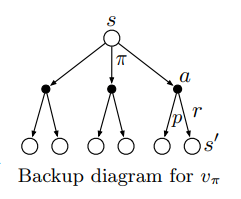

In [17]:
Image(r"images/backup_diagram_v.png", width=400)

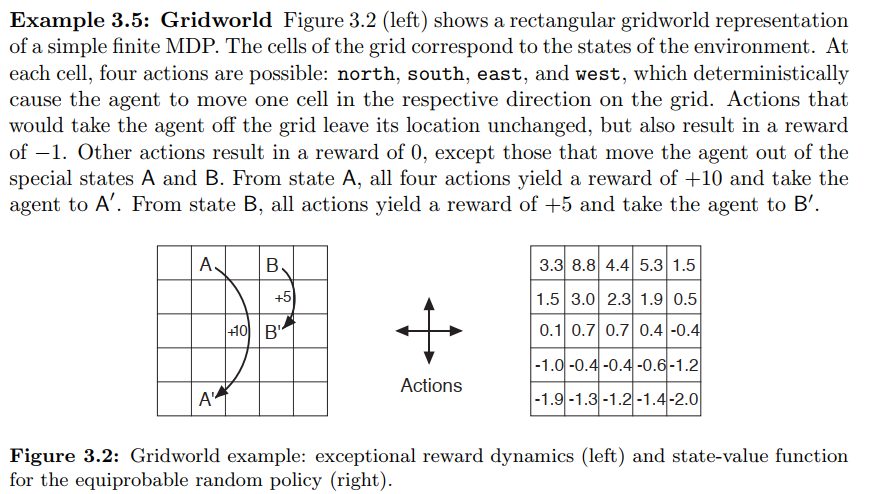

In [19]:
Image(r"images/gridworld.png", width=800)

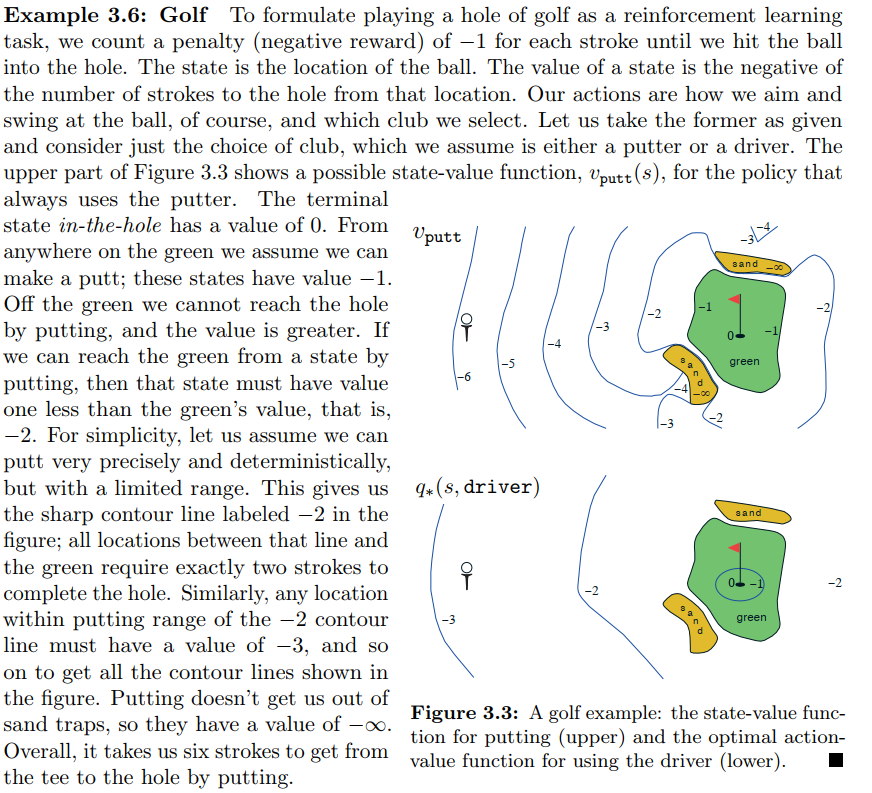

In [20]:
Image(r"images/golf.png", width=800)

### 3.5 Exercises

*Exercise 3.11: If the current state is $S_t$, and actions are selected according to stochastic policy $\pi$, then what is the expectation of $R_{t+1}$ in terms of $\pi$ and the four-argument function $p$?*

$$
\mathbb{E}_\pi[R_{t+1} \mid S_t = s] = \sum_a \pi(a \mid s) \sum_{s'} p(s', r \mid s, a) r
$$

*Exercise 3.12: Give an equation for $v_\pi$ in terms of $q_\pi$ and $pi$*

$$
v_\pi(s) = \sum_a \pi(a \mid s) \space q_\pi(s, a)
$$

*Exercise 3.13: Give an equation for $q_\pi$ in terms of $v_\pi$ and $p$*

$$
q_\pi(s, a) = \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma v_\pi(s')\right]
$$

*Exercise 3.14: The Bellman equation (3.14) must hold for each state for the value function $v_\pi$ shown in Figure 3.2 (right). Show numerically that this equation holds for the center state, valued at +0.7, with respect to its four neighboring states, valued at +2.3, +0.4, -0.4, and +0.7. (These numbers are accurate only to one decimal place.)*

$$
(0.25) \space (0.9) \space (2.3 + 0.4 - 0.4 + 0.7) \approx 0.7
$$

*Exercise 3.15: In the gridworld example, rewards are positive for goals, negative for running into the edge of the world, and zero the rest of the time. Are the signs of these rewards important, or only the intervals between them? Prove, using (3.8), that adding a constant $c$ to all the rewards adds a constant, $v_c$, to the values of all states, and thus does not affect the relative values of any states under any policies. What is $v_c$ in terms of $c$ and $\gamma$?*

Only the relative values (not necessarily the signs) of the rewards are important in determining the (relative) state-values.
From 3.8
$$
G_{t0} = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$$
and from 3.10, we know that for a constant reward:
$$
G_{t1} = \sum_{k=0}^{\infty} \gamma^k C = \frac{C}{1-\gamma}
$$
so to get our new $G_{t'}$ (with the added constant) we just add these two above, such that:
$$
G_{t'} = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1} + \frac{C}{1-\gamma}
$$
and $v_c$ is just this last term, $\frac{C}{1-\gamma}$. 

And since $G_{t1}$ does not depend on the state, we can write $v_\pi(s)$ as:
$$\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_{t0} + G_{t1} \mid S_t = s] \\
&= \mathbb{E}_\pi[G_{t0} \mid S_t = s] + G_{t1}
\end{aligned}$$
showing that the constant is added to the value of all states, thus not affecting the relative values.

*Exercise 3.16: Now consider adding a constant $c$ to all the rewards in an episodic task, such as maze running. Would this have any effect, or would it leave the task unchanged as in the continuing task above? Why or why not? Give an example.*

In a maze-running task, the constant value added _could_ change the state-values such that an earlier state now has more value than the (more heavily discounted) terminal state, so the agent may learn to never terminate, which would obviously change its expected behaviour.

For a really simple example, suppose that we have two states and two actions, $s_0, s_1 \text{ (terminal) }, a_0, a_1$, and $a_0$ takes agent $s_0 \rightarrow s_0 \text{ with } r = -1$ and $a_1$ takes agent $s_0 \rightarrow s_1 \text{ with } r = 1$. Now if we add a constant +2 to each reward, and we use a discounting factor $\gamma < 0.33$, the agent will prefer $a_0$ and choose this action forever.

*Exercise 3.17: What is the Bellman equation for action values, that is, for $q_\pi$? It must give the action value $q_\pi(s, a)$ in terms of the action values $q_\pi(s', a')$ of possible successors to the state–action pair $(s, a)$. Show the sequence of equations analogous to (3.14), but for action values.*
$$\begin{equation}\begin{aligned}
q_\pi(s, a) &= \mathbb{E}_\pi[G_t \mid S_t = s, A_t = a] \\
&= \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma \mathbb{E}_\pi[G_{t+1} \mid S_{t+1} = s', A_{t+1} = a'] \right] \\
&= \sum_{s', r} p(s', r \mid s, a) \left[r + \sum_{a'} \pi(a' \vert s') \gamma q_\pi(s', a') \right] 
\end{aligned}\end{equation}\tag{3.14}$$

*Exercise 3.18: The value of a state depends on the values of the actions possible in that state and on how likely each action is to be taken under the current policy. We can think of this in terms of a small backup diagram rooted at the state and considering each possible action. Give the equation corresponding to this intuition for the value at the root node, $v_\pi(s)$, in terms of the value at the expected leaf node, $q_\pi(s, a)$, given $S_t = s$. This equation should include an expectation conditioned on following the policy, $\pi$. Then give a second equation in which the expected value is written out explicitly in terms of $\pi (a \vert s)$ such that no expected value notation appears in the equation.*

$$\begin{aligned}
v_\pi(s) &= \mathbb{E} [q_\pi(s, a)] \\
&= \sum_a(\pi(a \vert s) q_\pi(s, a)
\end{aligned}$$

*Exercise 3.19: The value of an action, $q_\pi(s, a)$, depends on the expected next reward and the expected sum of the remaining rewards. Again we can think of this in terms of a small backup diagram, this one rooted at an action (state–action pair) and branching to the possible next states. Give the equation corresponding to this intuition for the action value, $q_\pi(s, a)$, in terms of the expected next reward, $R_{t+1}$, and the expected next state value, $v_\pi(S_{t+1})$, given that $S_t = s$ and $A_t = a$. This equation should include an expectation, but not one conditioned on following the policy. Then give a second equation, writing out the expected value explicitly in terms of $p(s', r \vert s, a)$, such that no expected value notation appears in the equation.* 

$$\begin{aligned}
q_\pi(s, a) &= \mathbb{E} [R_{t+1} v_\pi(S_{t+1})] \\
&= \sum_{s', r} p(s', r \mid s, a) [r + v_\pi(s')]
\end{aligned}$$

## 3.6 Optimal Policies and Optimal Value Functions

- For finite MDPs, a policy $\pi$ is defined to be $\geq$ another policy $\pi_2$ if its expected return is $\geq$ for all states. In other words, $\pi \geq \pi_2$ if and only if $v_\pi(s) \geq v_{\pi 2}$ for $s \in S$.
  - There is always at least one policy that is $\geq$ than all others: this is an **optimal policy**.
  - The **optimal state-value function** is denoted as:
  $$\begin{equation}
  v_*(s) = \underset{\pi}{\operatorname{max}}(v_\pi(s))
  \end{equation}\tag{3.15}$$
  - Similarly, the **optimal action-value function** is denoted as:
  $$\begin{equation}
  q_*(s, a) = \underset{\pi}{\operatorname{max}}(q_\pi(s, a))
  \end{equation}\tag{3.16}$$
  and we can rewrite it in terms of $v_*$ as:
  $$\begin{equation}
  q_*(s, a) = \mathbb{E}\left[R_{t+1} + \gamma v_* (S_{t+1}) \mid S_t = s, A_t = a\right]
  \end{equation}\tag{3.17}$$
- As the optimal value function, $v_*$'s Bellman equation can be written in a special form without reference to any specific policy, since it expresses the fact that the value of a state under an optimal policy must equal the expected return for the best action from that state. This special Bellman equation is known as the **Bellman optimality equation** and can be written for the state-value function $v$ as:
$$\begin{equation}\begin{aligned}
v_*(s) &= \underset{a \in A(s)}{\operatorname{max}}(q_{\pi*}(s, a)) \\
&= \underset{a}{\operatorname{max}} \mathbb{E}\left[R_{t+1} + \gamma v_* (S_{t+1}) \mid S_t = s, A_t = a\right] &\qquad \text{(from (3.17))} \\
&= \underset{a}{\operatorname{max}} \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma v_*(s')] \right] &\qquad \text{(from (3.13))}
\end{aligned}\end{equation}\tag{3.18, 3.19}$$
- Similarly, the Bellman optimality equation for the action-value function $q$ can be written as:
$$\begin{equation}\begin{aligned}
q_*(s, a) &= \mathbb{E}\left[R_{t+1} + \gamma \underset{a'}{\operatorname{max}} q_* (S_{t+1}, a') \big\vert S_t = s, A_t = a\right] \\
&= \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma \underset{a'}{\operatorname{max}} q_*(s', a')] \right]
\end{aligned}\end{equation}\tag{3.20}$$
- For finite MDPs, the Bellman optimality equation for $v_*$ (3.19) has a unique solution. However, unlike the Bellman equation for $v$ (a3.14.0 and a3.14.1), the Bellman optimality equation is a system of _non_ linear equations (due to the $max$ function), and in principle we can solve this using one of a variety of methods for solving systems of nonlinear equations (e.g. graphing, substitution, elimination, etc.). 
  - However, this relies on at least three properties that rarely hold true in practice: 1) fully known environment dynamics; 2) sufficient computational resources; 3) the Markov property.
    - e.g. in chess, 1) and 3) are true, but the compute and memory requirements are beyond the abilities of any contemporary computer, so the value of all possible states cannot be computed.
    - Therefore, we typically settle for approximate solutions using iterative methods.
- If we have $v_*$ or $q_*$, it is easy to find the optimal policy.
  - For $v_*$ we just have to take a greedy policy with respect to $v_*$: this is equivalent to doing a one-step search from the current state and choosing the action that takes you to the successor state that has the greatest value out of all the possible successor states.
  - For $q_*$ it's even simpler, we just follow a policy that takes the action that maximizes $q_*$ out of all the possible actions.
    - Thus, at the cost of representing state-action pairs instead of just states, if we implement a policy based on $q_*$ we don't need to know anything about the successor states and their values (i.e. the environment's dynamics).

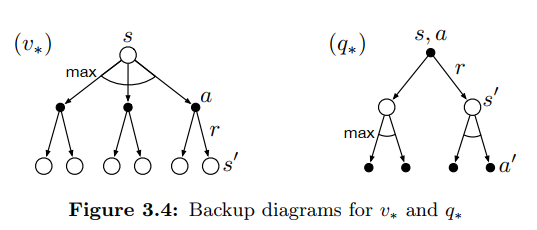

In [23]:
Image(r"images/backup_diagram_optimal_v.png", width=600)

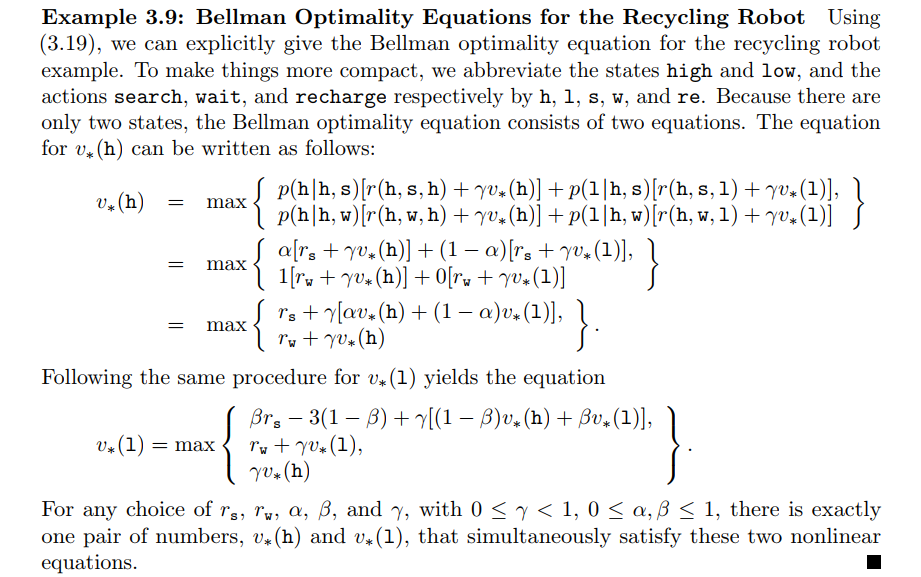

In [25]:
Image(r"images/bellman_optimality_recycling_robot.png", width=800)

### 3.6 Exercises

*Exercise a3.19: From Example 3.9, choose a set of reasonable values for $r_s$, $r_w$, $\alpha$, $\beta$, and $\gamma$, and analytically solve the set of nonlinear equations for $v_*(h)$ and $v_*(l)$, showing what the action-values of each state are - $q(s, a)$ - and therefore what the optimal action should be for each state.*

If we choose $r_s = 2; r_w = 1; \alpha = \beta = \gamma = 0.9$, then for the "high" state $v_*(h)$, we solve for we solve $v_*(h)$ and $v_*(l)$ (which we will simplify to $h$ and $l$) in the "search" and "wait" actions, as follows:

$$\begin{aligned}
\text{solve for $h$ in "wait"}: \\
0 &= r_w + \gamma h - h \\
-1 &= -0.1h \\
h &= 10 \\
\text{solve for $l$ in "search"}: \\
0 &= r_s + \gamma [\alpha h + (1 - \alpha) l] - h \\
0.8 &= 0.1l \\
l &= 8
\end{aligned}$$

Then given these values, we find the associated action-values:
$$
v_*(h) = \operatorname{max}
\begin{cases}
r_w + \gamma h = 10 & \text{"wait"} \\
r_s + \gamma [\alpha h + (1 - \alpha) l] = 10.82 & \text{"search"}
\end{cases}
$$

*Exercise 3.20: Draw or describe the optimal state-value function for the golf example.*

$v_{driver}$ everywhere outside the green, and $v_{putt}$ inside the green.

*Exercise 3.21: Draw or describe the contours of the optimal action-value function for putting, $q_*(s, putter)$, for the golf example.*

The same as the contours for $v_{putt}$.

*Exercise 3.22: Consider a continuing MDP with three states (a, b, c) and two actions (left, right). The transitions are given by:* 
$$
a, left \rightarrow b \text{ ; } r = 1 \\
a, right \rightarrow c \text{ ; } r = 0 \\ 
b, left \rightarrow a \text{ ; } r = 0 \\
c, right \rightarrow a \text{ ; } r = 2
$$

*From state $a$ there are exactly two deterministic policies, always left, and always right. What policy is optimal if $\gamma$ = 0? If $\gamma$ = 0.9?
If $\gamma$ = 0.5?*

The left policy will always yield a value of $0.5$ ($\frac{1}{2})$, so due to discounting,
$$
\operatorname{optimal} =
\begin{cases}
\gamma = 0.5 & \text{both} \\
\gamma < 0.5 & \text{left} \\
\gamma > 0.5 & \text{right}
\end{cases}
$$

*Exercise 3.23: Give the Bellman equation for $q_*$ for the recycling robot.*

We can just plug-in the appropriate values for the given state-action pair into equation 3.20.
$$
\sum_{s', r} p(s', r \mid s, a) \left[r + \gamma \underset{a'}{\operatorname{max}} q_*(s', a')] \right]
$$
For example, for (high, wait), since the only possible successor state is high, and since $r_{search} > r_{wait}$:
$$
r_{wait} + \gamma q_*(high, search)
$$

and for (high, search):
$$
(\alpha) [r_{search} + \gamma q_*(high, search)] \\
+ (1 - \alpha) [r_{search} + \gamma q_*(low, search)]
$$

*Exercise 3.24: Figure 3.5 gives the optimal value of the best state of the gridworld as $24.4$, to one decimal place. Use your knowledge of the optimal policy and (3.8) to express this value symbolically, and then to compute it to three decimal places.*

The optimal poliicy from A is to move anywhere, and then move back to A through 4 "up" moves. So in total, we get a reward of 10 every 5 steps. We can write the value as:
$$\begin{aligned}
v_*(A) &= \sum_{k=0}^{\infty} 10 \times 0.9^{5k} \\
&= \frac{10}{1 - 0.9^5} = 24.419
\end{aligned}$$

*Exercise 3.25: Give an equation for $v_*$ in terms of $q_*$.*

$$
v_*(s) = \underset{a}{\operatorname{max}}(q_*(s, a))
$$

*Exercise 3.26: Give an equation for $q_*$ in terms of $v_*$ and the four-argument $p$.*

$$
q_*(s, a) = \sum_{s', r} p(s', r \vert s, a) \left[r + \gamma v_*(s')\right]
$$

*Exercise 3.27: Give an equation for $\pi_*$ in terms of $q_*$.*

$$
\pi_* = \underset{a}{\operatorname{argmax}} q_*(s, a)
$$

*Exercise 3.28: Give an equation for $\pi_*$ in terms of $v_*$ and the four-argument $p$.*

$$
\pi_* = \underset{a}{\operatorname{argmax}} \sum_{s', r} p(s', r \vert s, a) \left[r + \gamma v_*(s')\right]
$$

*Exercise 3.29: Rewrite the four Bellman equations for the four value functions ($v_\pi, v_*, q_\pi, \text{ and } q_*$) in terms of the three-argument function $p(s' \vert s, a)$ (3.4) and the two-argument function $r(s,a)$ (3.5).*

$$
v_\pi(s) = \sum_{a} \pi(a \vert s) \sum_{a} r(s, a) + \sum_{s'} p(s' \vert s, a) [\gamma v_\pi(s')]
$$

$$
q_\pi(s) = r(s, a) + \sum_{a'} \pi(a', s') q_\pi(s', a') \sum_{s'} p(s' \vert s, a) \gamma
$$
